In [8]:
import torch
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np

In [9]:
torch.cuda.is_available()
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev)
device

device(type='cuda')

## Modelo proposto por Rockne

Rockne et al. propôs uma extensão do modelo de Murray, a partir de um termo na equação proposta por Murray, com a finalidade de descrever os efeitos causados pela radioterapia na
dinâmica de crescimento do tumor:

$$
\dfrac{\partial c}{\partial t} = \bigtriangledown \cdot (\bigtriangledown c) + pc - R(\alpha, d)c
$$

onde:
- $c(x,t)$: Concentração de células tumorais por mm³
- $D$: Coeficiente de difusão dado em mm²/dia (representa a mortalidade da célula)
- $p$: Taxa de proliferação em 1/dia
- $d(x,t)$: Dose fracionada definida no espaço e tempo
- $\alpha$: Parâmetro de sensibilidade à radiação.

In [10]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()    

In [11]:
#PARAMETROS
D = 0.0013
p = 0.453
L = 2
c0 = 8e5
alpha = 0.0305
alpha_beta = 10.0

Dl = D / (p * L**2)

#DOMINIO ESPACIAL E TEMPORAL
x_dom = (0, 1)
t_dom = (0, 100)

#ADIMENSIONALIZAÇÃO
batch_size = 1000
x = torch.FloatTensor(batch_size).uniform_(x_dom[0], x_dom[1]).requires_grad_().to(device)
t = torch.FloatTensor(batch_size).uniform_(t_dom[0], t_dom[1]).requires_grad_().to(device)  * p

#PLANO TRATAMENTO
dose = torch.tensor([12.2, 12.2, 12.2, 12.2, 12.2, 12.2], dtype = torch.float32, device = device, requires_grad = True)
n = 1
t_doses = torch.tensor([8,9,10,11,12,23], dtype = torch.float32, device = device, requires_grad=True)
x_doses = torch.rand_like(t_doses, dtype= torch.float32, device = device, requires_grad= True)

#VALORES DE ENTRADA
x0 = torch.tensor([L], dtype=torch.float32).to(device)
t0 = torch.tensor([0.], dtype=torch.float32).to(device)

#PREPARAÇÃO DOS DADOS
input_pde = torch.cartesian_prod(x, t).to(device)
input_ic1 = torch.cartesian_prod(x, t0).to(device)
input_ic2 = torch.cartesian_prod(x0, t).to(device)
ic_target = L**3 * torch.exp(-100 * x**2 / L).to(device)

#DECLARAÇÃO DA ARQUITETURA USADA
model = NeuralNetwork(2, 1, 80, 1, torch.nn.Tanh()).to(device) # 1 input, 1 camada oculta, 20 neurônios/cam. oculta, 1 output, activação: Tanh

#PARAMETROS DO TREINAMENTO
epochs = 5000
optmizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = torch.nn.MSELoss()

In [12]:
#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
print(dose)

a = (dose / alpha_beta)
print(a)

a = (1 + dose / alpha_beta)
print(a)

tensor([12.2000, 12.2000, 12.2000, 12.2000, 12.2000, 12.2000], device='cuda:0',
       requires_grad=True)
tensor([1.2200, 1.2200, 1.2200, 1.2200, 1.2200, 1.2200], device='cuda:0',
       grad_fn=<DivBackward0>)
tensor([2.2200, 2.2200, 2.2200, 2.2200, 2.2200, 2.2200], device='cuda:0',
       grad_fn=<AddBackward0>)


In [13]:
#DECLARAÇÃO DA EQUAÇÃO DIFERENCIAL
def R(dose = dose, n = n):
    return (1.0 - torch.exp(-alpha * n * dose * (1 + dose / alpha_beta))) / p

def DifusaoReacao_com_tratamento(x, t, model):

    input = torch.stack((x, t),1)
    c = model(input)

    cl = (c * L**3) / c0

    c_t = torch.autograd.grad(cl.sum(), t, create_graph = True)[0]
    c_x = torch.autograd.grad(cl.sum(), x, create_graph = True)[0]

    c_xx = torch.autograd.grad(c_x.sum(), x, create_graph = True)[0]
    
    residual = c_t - (Dl * c_xx - R() * cl)
    
    zero = torch.zeros_like(residual)
    return loss_fn(residual, zero)

def DifusaoReacao_sem_tratamento(x, t, model):

    input = torch.stack((x, t),1)
    c = model(input)

    cl = (c * L**3) / c0

    c_t = torch.autograd.grad(cl.sum(), t, create_graph = True)[0]
    c_x = torch.autograd.grad(cl.sum(), x, create_graph = True)[0]

    c_xx = torch.autograd.grad(c_x.sum(), x, create_graph = True)[0]
    
    residual = c_t - (Dl * c_xx - cl)

    zero = torch.zeros_like(residual)
    return loss_fn(residual, zero)


In [14]:
#TREINAMENTO
l_map = []

for ep in range(epochs):
    

    #CALCULO DO CUSTO PARA A CONDIÇÃO DE CONTORNO
    out_ic= model(input_ic1)
    l1 = loss_fn(out_ic, ic_target)

    out_ic= model(input_ic2)
    ic_target2 = torch.zeros_like(out_ic)
    l2 = loss_fn(out_ic, ic_target2)

    #CALCULO DO CUSTO PARA A EDP SEM TRATAMENTO
    l3 = DifusaoReacao_sem_tratamento(x, t, model)

    #CALCULO DO CUSTO PARA A EDP COM TRATAMENTO
    l4 = DifusaoReacao_com_tratamento(x_doses, t_doses, model)
    
    #BACKPROPAGATION
    loss = l1 + l2 + l3 + l4
    l_map.append(loss.item())

    loss.backward(retain_graph=True)
    optmizer.step()
    optmizer.zero_grad()

    with torch.autograd.no_grad():
        if ep % 1000 == 0:
            print(f'Epochs: {ep}/{epochs} Loss: {loss.item()}')

Epochs: 0/5000 Loss: 5.405579090118408
Epochs: 1/5000 Loss: 5.071934700012207
Epochs: 2/5000 Loss: 4.925131797790527
Epochs: 3/5000 Loss: 4.807222366333008
Epochs: 4/5000 Loss: 4.681126117706299
Epochs: 5/5000 Loss: 4.578256607055664
Epochs: 6/5000 Loss: 4.499602794647217
Epochs: 7/5000 Loss: 4.437665939331055
Epochs: 8/5000 Loss: 4.385199069976807
Epochs: 9/5000 Loss: 4.336728096008301
Epochs: 10/5000 Loss: 4.288712501525879
Epochs: 11/5000 Loss: 4.239343166351318
Epochs: 12/5000 Loss: 4.188108921051025
Epochs: 13/5000 Loss: 4.135332107543945
Epochs: 14/5000 Loss: 4.081754684448242
Epochs: 15/5000 Loss: 4.028234958648682
Epochs: 16/5000 Loss: 3.9755306243896484
Epochs: 17/5000 Loss: 3.9241883754730225
Epochs: 18/5000 Loss: 3.874518394470215
Epochs: 19/5000 Loss: 3.8266232013702393
Epochs: 20/5000 Loss: 3.78045916557312
Epochs: 21/5000 Loss: 3.7358922958374023
Epochs: 22/5000 Loss: 3.6927490234375
Epochs: 23/5000 Loss: 3.6508567333221436
Epochs: 24/5000 Loss: 3.610084295272827
Epochs: 

NeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=80, bias=True)
    (2): Tanh()
    (3): Linear(in_features=80, out_features=1, bias=True)
  )
)

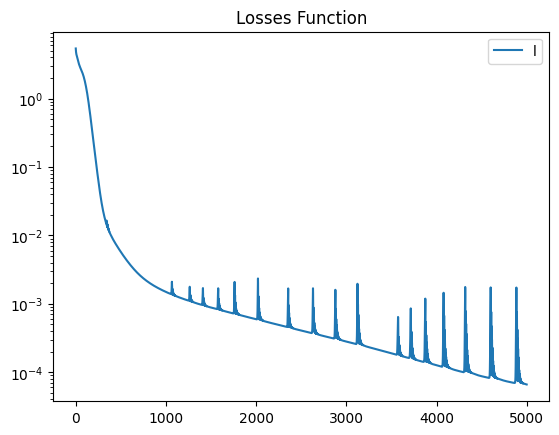

In [15]:
plt.plot(np.arange(0, epochs, 1), l_map, label = 'l')
plt.yscale('log')
plt.title('Losses Function')
plt.legend()
plt.show()

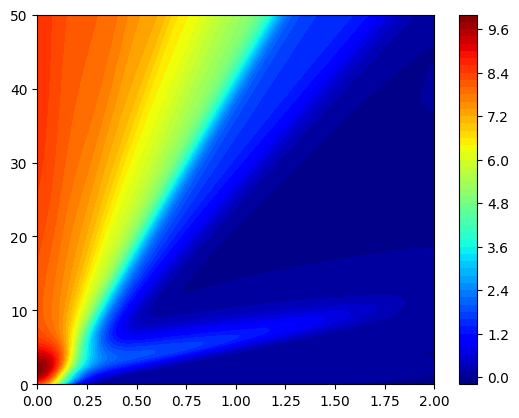

In [16]:
size = 1000
x_dom = (0, L)
t_dom = (0, 50)
x = torch.linspace(x_dom[0], x_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
t = torch.linspace(t_dom[0], t_dom[1], size, dtype=torch.float32, requires_grad=True).to(device)
input = torch.cartesian_prod(x, t)
out = model(input)

x = x.cpu().detach().numpy()
t = t.cpu().detach().numpy()
out = out.cpu().detach().numpy()

X, T = np.meshgrid(x, t)
out = np.reshape(out, (size, size)).T

plt.contourf(X, T, out, levels = 50, cmap = 'jet')
plt.colorbar()


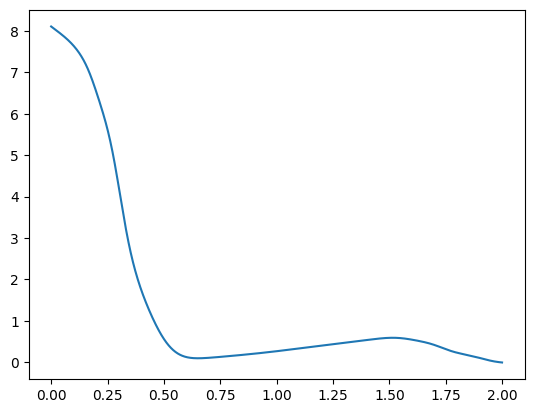

In [59]:
size = 1000
dx = 0.001
t = torch.tensor([10.]).to(device)
x = torch.arange(x_dom[0], x_dom[1], dx, dtype=torch.float32, requires_grad=True).to(device)
input = torch.cartesian_prod(x, t)
out = model(input)

x = x.cpu().detach().numpy()
out = out.cpu().detach().numpy()

plt.plot(x, out)

In [46]:
#CALCULO DO RAIO TUMORAL
size = 1000
dx = 0.001
t = torch.tensor([35.]).to(device)
x = torch.arange(x_dom[0], x_dom[1], dx, dtype=torch.float32, requires_grad=True).to(device)
input = torch.cartesian_prod(x, t)
out = model(input)

def raio_tumoral(concentracao):
    for i, k in zip(concentracao, range(len(concentracao))):
        if i == min(concentracao) and k < 3: return 0
        return (k-2)*dx

raio_tumoral(out)

-0.002